# 無限時間最適フィードバック制御モデル
## モデルの構造
**無限時間最適フィードバック制御モデル** (**infinite-horizon optimal feedback control model**) {cite:p}`Qian2013-zy`

$$
\begin{align}
d x&=(\mathbf{A} x+\mathbf{B} u) dt +\mathbf{Y} u d \gamma+\mathbf{G} d \omega \\
d y&=\mathbf{C} x dt+\mathbf{D} d \xi\\
d \hat{x}&=(\mathbf{A} \hat{x}+\mathbf{B} u) dt+\mathbf{K}(dy-\mathbf{C} \hat{x} dt)
\end{align}
$$

## 実装
ライブラリの読み込みと関数の定義．

In [1]:
using Parameters: @unpack
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot
rc("axes.spines", top=false, right=false)
rc("font", family="Arial") 

定数の定義

$$
\begin{align}
\alpha_{1}&=\frac{b}{t_{a} t_{e} I},\quad \alpha_{2}=\frac{1}{t_{a} t_{e}}+\left(\frac{1}{t_{a}}+\frac{1}{t_{e}}\right) \frac{b}{I} \\
\alpha_{3}&=\frac{b}{I}+\frac{1}{t_{a}}+\frac{1}{t_{e}},\quad b_{u}=\frac{1}{t_{a} t_{e} I}
\end{align}
$$

In [2]:
@kwdef struct SaccadeModelParameter
    n = 4 # number of dims
    i = 0.25 # kgm^2, 
    b = 0.2 # kgm^2/s
    ta = 0.03 # s
    te = 0.04 # s
    L0 = 0.35 # m

    bu = 1 / (ta * te * i)
    α1 = bu * b
    α2 = 1/(ta * te) + (1/ta + 1/te) * b/i
    α3 = b/i + 1/ta + 1/te

    A = [zeros(3) I(3); -[0, α1, α2, α3]']
    B = [zeros(3); bu]
    C = [I(3) zeros(3)]
    D = Diagonal([1e-3, 1e-2, 5e-2])

    Y = 0.02 * B
    G = 0.03 * I(n)

    Q = Diagonal([1.0, 0.01, 0, 0]) 
    R = 0.0001
    U = Diagonal([1.0, 0.1, 0.01, 0])
end

SaccadeModelParameter

In [38]:
using ProgressMeter

In [4]:
param = SaccadeModelParameter();

### シミュレーション
関数を書く．

In [64]:
function simulation(param::SaccadeModelParameter, L, dt=0.001, T=2.0, init_pos=-0.5)
    @unpack n, A, B, C, D, Y, G, Q, R, U = param
    nt = round(Int, T/dt)
    X = zeros(n, nt)
    u = zeros(nt)
    X[1, 1] = init_pos # m; initial position (target position is zero)
    sqrtdt = √dt
    z = zeros(n)
    for t in 1:nt-1
        xi = randn()
        u[t] = -L * X[:, t]
        X[:, t+1] = X[:,t] + (A * X[:,t] + B * u[t]) * dt #+ sqrtdt * (Y * u[t] * randn() + G * randn(n))
        z += 
    end
    return X, u
end

simulation (generic function with 4 methods)

In [87]:
dt = 1e-3
T = 1.0
n = 4
η = 1e-2;

FW = rand(n);# .- 0.5;
num_iter = 1000

1000

In [95]:
nt = round(Int, T/dt)

1000

In [96]:
error_arr = zeros(num_iter);

L = 1e-2*randn(n)';
@showprogress for i in 1:num_iter
    X, u = simulation(param::SaccadeModelParameter, L)
    error = sum(X[1, :]) / nt#X[1, end]
    L = L - η * (FW * error)'
    error_arr[i] = sum(error .^ 2)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [94]:
sum(X[1, :])

-766.7777315052122

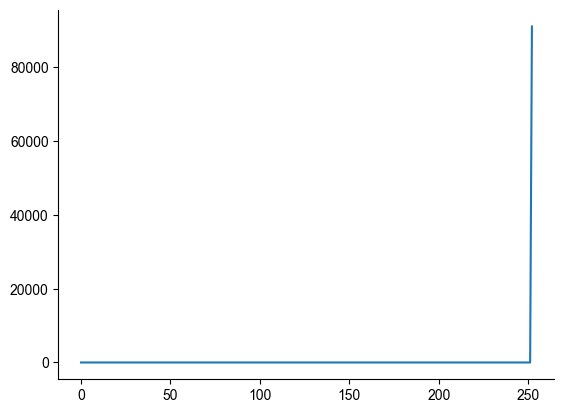

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000002233B1D2900>

In [97]:
plot(error_arr)

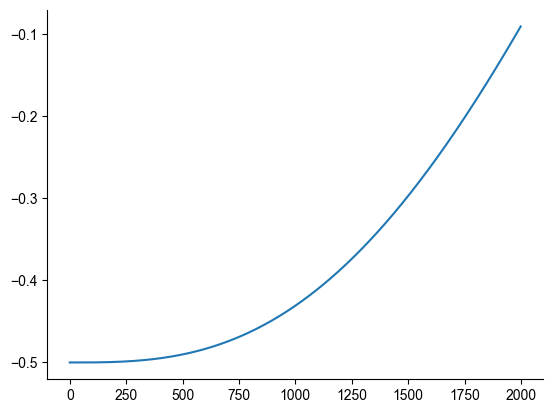

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000002233B162840>

In [90]:
plot(X[1, :])

1×4 adjoint(::Vector{Float64}) with eltype Float64:
 -0.000592295  0.000517009  0.00048171  -0.000917384

In [12]:
size(X)

(4, 2000)

理想状況でのシミュレーション

1.0

In [8]:
Xa, ua = simulation(param, L, K, dt, T, noisy=false);

### ノイズを含むシミュレーション
ノイズを含む場合．

In [9]:
n = 4
nsim = 10
XSimAll = []
uSimAll = []
for i in 1:nsim
    XSim, u = simulation(param, L, K, dt, T, noisy=true);
    push!(XSimAll, XSim)
    push!(uSimAll, u)
end

結果の描画

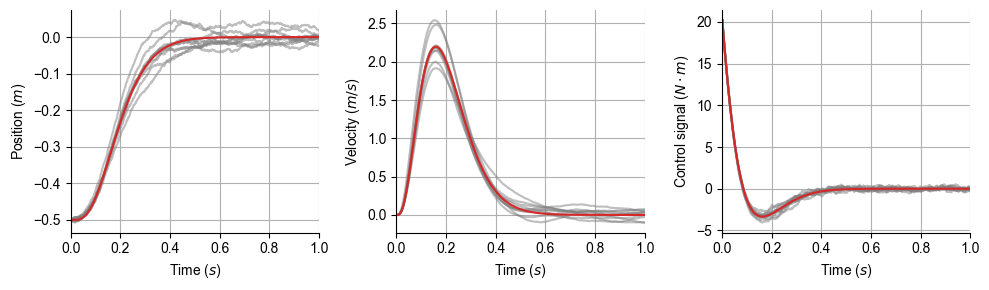

In [10]:
tarray = collect(dt:dt:T)
label = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]

fig, ax = subplots(1, 3, figsize=(10, 3))
for i in 1:2
    for j in 1:nsim
        ax[i].plot(tarray, XSimAll[j][i,:]', "tab:gray", alpha=0.5)
    end
    
    ax[i].plot(tarray, Xa[i,:], "tab:red")
    ax[i].set_ylabel(label[i]); ax[i].set_xlabel(L"Time ($s$)"); ax[i].set_xlim(0, T); ax[i].grid()
end

for j in 1:nsim
    ax[3].plot(tarray, uSimAll[j], "tab:gray", alpha=0.5)
end
ax[3].plot(tarray, ua, "tab:red")
ax[3].set_ylabel(L"Control signal ($N\cdot m$)"); ax[3].set_xlabel(L"Time ($s$)"); ax[3].set_xlim(0, T); ax[3].grid()

tight_layout()